In [1]:
import sys
import torch
sys.path.append("..")

from torch.utils.data import DataLoader, TensorDataset
from pytorch_utils import *
from preprocess import *
from model_container import ModelContainer

In [2]:
resnet50 = ModelContainer(
    nnet = get_instrument_segmentation_model_base(
        Models.RESNETV50
    ),
    returns_dict = True
)

unet = ModelContainer(
    nnet = get_instrument_segmentation_model_base(
        Models.UNET
    ),
    returns_dict = False
)

input_shape = (96, 128)

custom = \
    ModelContainer(
        get_instrument_segmentation_model_base(Models.CUSTOM, shape = input_shape),
        returns_dict = False
    )

In [3]:
resnet50.load_model(torch.load("..\\training\\pickled\\resnet50_model_full.pkl"))
unet.load_model(torch.load("..\\training\\pickled\\unet_model_full.pkl"))
custom.load_model(torch.load("..\\training\\pickled\\custom_model_full.pkl"))

In [4]:
resnet50_losses = torch.load(r"..\training\pickled\resnet50_losses_full.pkl")
unet_losses = torch.load(r"..\training\pickled\unet_losses_full.pkl")
custom_losses = torch.load(r"..\training\pickled\custom_losses_full.pkl")

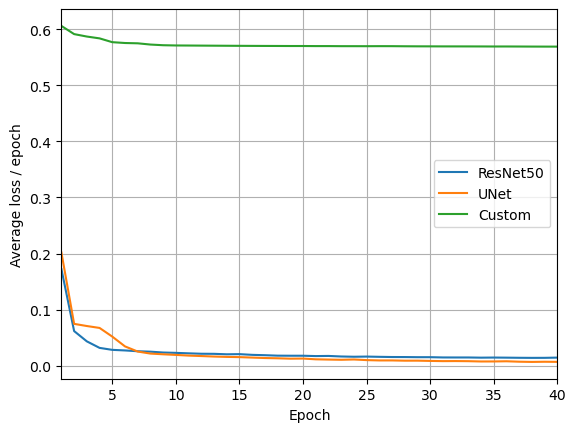

In [5]:
I = 4480 // 128 # number of samples
N = 40 # number of samples

import matplotlib.pyplot as plt
plt.figure()
plt.plot(np.arange(N) + 1, np.average(np.array(resnet50_losses).reshape(-1, I), axis = 1), label = "ResNet50")
plt.plot(np.arange(N) + 1, np.average(np.array(unet_losses).reshape(-1, I), axis = 1), label = "UNet")
plt.plot(np.arange(N) + 1, np.average(np.array(custom_losses).reshape(-1, I), axis = 1), label = "Custom")
plt.ylabel("Average loss / epoch")
plt.xlabel("Epoch")
plt.xlim([1, N])
plt.grid()
plt.legend()

In [6]:
np.average(np.array(custom_losses).reshape(-1, I), axis = 1)[-1]

0.5688898835863386

In [7]:
input_, output_ = load_endovis_videos(DatasetType.TESTING)

# for some reason, two of the videos for the output had an extra frame.
# removing the last frame of said videos in order to somewhat sync them back up,
# but ideally the correct frame would be removed...
DROPOUT = (4496, 1495+1500)

for idx in DROPOUT:
    output_.pop(idx)

input_to_tensor = preprocess_source_endovis_images(input_, (96, 128))
output_to_tensor = preprocess_endovis_target_images(output_, (96, 128))

In [8]:
dataset = TensorDataset(input_to_tensor, output_to_tensor)

In [9]:
output_to_tensor.shape

torch.Size([4495, 3, 96, 128])

In [10]:
results = []

for idx in range(input_to_tensor.shape[0]):
    results.append(unet.test(
        input_to_tensor[idx:idx+1], 
        output_to_tensor[idx:idx+1]
    ))

In [11]:
results

[0.9619188904762268,
 0.9480229020118713,
 0.9529237151145935,
 0.9507389068603516,
 0.937066376209259,
 0.937700092792511,
 0.9395577311515808,
 0.9307560324668884,
 0.9290763139724731,
 0.917573094367981,
 0.9205505847930908,
 0.9277603030204773,
 0.9382063150405884,
 0.9390302300453186,
 0.9342262744903564,
 0.9073053598403931,
 0.9318996667861938,
 0.936302661895752,
 0.9254229068756104,
 0.9288087487220764,
 0.9343374967575073,
 0.941534161567688,
 0.9473932385444641,
 0.9441696405410767,
 0.9429783225059509,
 0.9393300414085388,
 0.9312763214111328,
 0.926601231098175,
 0.9291375279426575,
 0.9253451824188232,
 0.9290352463722229,
 0.9282563328742981,
 0.9298978447914124,
 0.8937745690345764,
 0.8843823075294495,
 0.8993194103240967,
 0.9099014401435852,
 0.8963730335235596,
 0.8702869415283203,
 0.8552916049957275,
 0.8665207624435425,
 0.8584027290344238,
 0.8830076456069946,
 0.8813895583152771,
 0.8702783584594727,
 0.8654274940490723,
 0.8486055731773376,
 0.8387421369552612

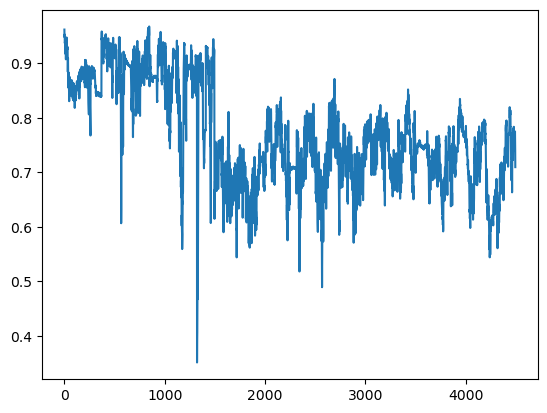

In [12]:
plt.plot(results)

In [13]:
np.average(results), np.std(results)

(0.7688459486531733, 0.09311924761794488)

In [14]:
results2 = []

for idx in range(input_to_tensor.shape[0]):
    results2.append(resnet50.test(
        input_to_tensor[idx:idx+1], 
        output_to_tensor[idx:idx+1]
    ))

In [15]:
results2

[0.9307028651237488,
 0.9305760860443115,
 0.9317229390144348,
 0.9354997277259827,
 0.9332676529884338,
 0.9358472228050232,
 0.9335613250732422,
 0.9341170787811279,
 0.9331695437431335,
 0.9204795956611633,
 0.9229273200035095,
 0.9298160672187805,
 0.925000011920929,
 0.9265129566192627,
 0.9309002161026001,
 0.9274523854255676,
 0.9350275993347168,
 0.9345749616622925,
 0.9289461374282837,
 0.9298493266105652,
 0.9307164549827576,
 0.9339957237243652,
 0.9357193112373352,
 0.9323272705078125,
 0.9278982281684875,
 0.9270124435424805,
 0.9270466566085815,
 0.9286215901374817,
 0.9340839982032776,
 0.9307349324226379,
 0.9314553737640381,
 0.9288056492805481,
 0.9215319752693176,
 0.9278982281684875,
 0.9265643358230591,
 0.9286561012268066,
 0.9263455867767334,
 0.9224567413330078,
 0.9189059734344482,
 0.9038042426109314,
 0.8910987377166748,
 0.89239102602005,
 0.9114236235618591,
 0.9019995331764221,
 0.8988540172576904,
 0.8745964765548706,
 0.8428211808204651,
 0.8373494148254

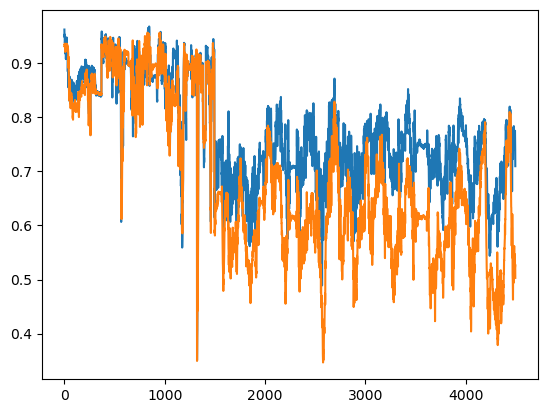

In [16]:
plt.plot(results)
plt.plot(results2)

In [17]:
np.average(results2), np.std(results2)

(0.6886683013667254, 0.14402446215157785)

In [18]:
results3 = []

for idx in range(input_to_tensor.shape[0]):
    results3.append(custom.test(
        input_to_tensor[idx:idx+1], 
        output_to_tensor[idx:idx+1]
    ))

C:\Users\thegr\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [19]:
results3

[0.9386562705039978,
 0.9437271356582642,
 0.938199520111084,
 0.9344978332519531,
 0.9262135624885559,
 0.9264741539955139,
 0.9254958629608154,
 0.9273122549057007,
 0.9280038475990295,
 0.9236294031143188,
 0.9203540086746216,
 0.9181188941001892,
 0.9146660566329956,
 0.9197149872779846,
 0.9198012948036194,
 0.9171192646026611,
 0.9110690355300903,
 0.9151343703269958,
 0.9163516163825989,
 0.9224586486816406,
 0.9170387983322144,
 0.9234022498130798,
 0.9244131445884705,
 0.92188960313797,
 0.9196261763572693,
 0.9168025851249695,
 0.914913535118103,
 0.9100677371025085,
 0.9176360964775085,
 0.913928747177124,
 0.9150899648666382,
 0.9199169278144836,
 0.9214780330657959,
 0.915900707244873,
 0.9077948927879333,
 0.9026589393615723,
 0.8984031677246094,
 0.899350643157959,
 0.8937660455703735,
 0.8797364234924316,
 0.8818596005439758,
 0.875151515007019,
 0.896652102470398,
 0.8951082825660706,
 0.8828697204589844,
 0.8657373189926147,
 0.8630644083023071,
 0.8572136759757996,
 

In [20]:
SIZES = (370, 375, 375, 375, 1500, 1500)
INDEXES = [0]
for size in SIZES:
    INDEXES.append(INDEXES[-1] + size - 1)

In [21]:
INDEXES

[0, 369, 743, 1117, 1491, 2990, 4489]

In [41]:
%matplotlib qt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(results2, label = "ResNet50", alpha = 0.5)
ax.plot(results, label = "UNet", alpha = 0.5)
ax.plot(results3, label = "Custom", alpha = 0.5)
for idx in range(len(INDEXES)):
    ax.axvline(INDEXES[idx], 0, 1, color = "red", linestyle = "dashed")
    if idx != len(INDEXES)-1:
        for r in (results2, results, results3):
            print(f"Average coeff: {np.average(r[INDEXES[idx]:INDEXES[idx+1]+1]):.4f} +/- {np.std(r[INDEXES[idx]:INDEXES[idx+1]+1]):.4f}")
        print("------------")

ax.set_axisbelow(True)
ax.set_ylim([0.0, 1.0])
ax.set_ylabel("Dice coefficient")
# ax.set_xticklabels([])
ax.legend()
ax.grid()

Average coeff: 0.8531 +/- 0.0339
Average coeff: 0.8704 +/- 0.0293
Average coeff: 0.8765 +/- 0.0251
------------
Average coeff: 0.8854 +/- 0.0571
Average coeff: 0.8922 +/- 0.0447
Average coeff: 0.9071 +/- 0.0305
------------
Average coeff: 0.8757 +/- 0.0458
Average coeff: 0.8869 +/- 0.0403
Average coeff: 0.8877 +/- 0.0510
------------
Average coeff: 0.8350 +/- 0.0956
Average coeff: 0.8352 +/- 0.1008
Average coeff: 0.8493 +/- 0.0902
------------
Average coeff: 0.6093 +/- 0.0756
Average coeff: 0.7099 +/- 0.0567
Average coeff: 0.6788 +/- 0.0710
------------
Average coeff: 0.5958 +/- 0.0847
Average coeff: 0.7261 +/- 0.0538
Average coeff: 0.6898 +/- 0.0492
------------


In [23]:
np.average(results3), np.std(results3)

(0.7492614914697322, 0.11041022468943125)

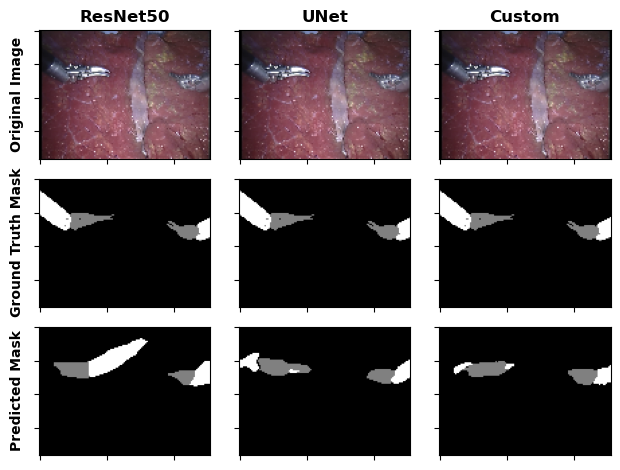

In [40]:
%matplotlib inline
fig, ax = plt.subplots(3, 3)
# im_source, im_target = get_random_image(dataset)
im_source, im_target = dataset[2581]

ax[0,0].set_ylabel("Original Image", rotation = 90, fontweight = 'bold')
ax[1,0].set_ylabel("Ground Truth Mask", rotation = 90, fontweight = 'bold')
ax[2,0].set_ylabel("Predicted Mask", rotation = 90, fontweight = 'bold')

ax[0,0].set_title("ResNet50", fontweight = 'bold')
ax[0,1].set_title("UNet", fontweight = 'bold')
ax[0,2].set_title("Custom", fontweight = 'bold')

for i, model in enumerate((resnet50, unet, custom)):
    ax[0, i].imshow(reshape_to_rgb(im_source))
    ax[1, i].imshow(to_n_channel_pred_single(im_target.data.cpu()), cmap = "gray")
    ax[2, i].imshow(model.predict(im_source), cmap = "gray")
    for ii in range(3):
        ax[ii, i].set_xticklabels([])
        ax[ii, i].set_yticklabels([])
        

plt.tight_layout()
# ax[0,0].tick_params(axis = 'y', labelrotation = 90)

In [25]:
(370*0.8531 + 1500*0.6093 + 1500*0.5958) / 3370

0.6300584569732938

In [26]:
(370*0.8704 + 1500*0.7099 + 1500*0.7261) / 3370

0.7347323442136497

In [27]:
(370*0.8765 + 1500*0.6788 + 1500*0.6898) / 3370

0.7054020771513353

In [28]:
(375*0.8854 + 375*0.8757 + 375*0.8350) / 1125

0.8653666666666666

In [29]:
(375*0.8922 + 375*0.8869 + 375*0.8352) / 1125

0.8714333333333334

In [30]:
(375*0.9071 + 375*0.8877 + 375*0.8493) / 1125

0.8813666666666666

In [31]:
input_[0].shape

(576, 720, 3)

[Text(0, -20.0, ''),
 Text(0, 0.0, ''),
 Text(0, 20.0, ''),
 Text(0, 40.0, ''),
 Text(0, 60.0, ''),
 Text(0, 80.0, ''),
 Text(0, 100.0, '')]

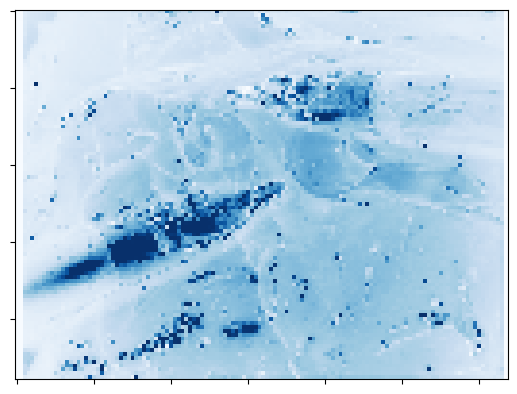

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
rgb = cv.cvtColor(input_[0], code = cv.COLOR_BGR2RGB)
ax.imshow(cv.resize(rgb[:,:,2], (128, 96)), cmap = "Blues")
# ax.imshow(rgb[:,:,1], cmap = "gray")
# ax.imshow(rgb[:,:,2], cmap = "gray")
ax.set_xticklabels([])
ax.set_yticklabels([])

[Text(0, -20.0, ''),
 Text(0, 0.0, ''),
 Text(0, 20.0, ''),
 Text(0, 40.0, ''),
 Text(0, 60.0, ''),
 Text(0, 80.0, ''),
 Text(0, 100.0, '')]

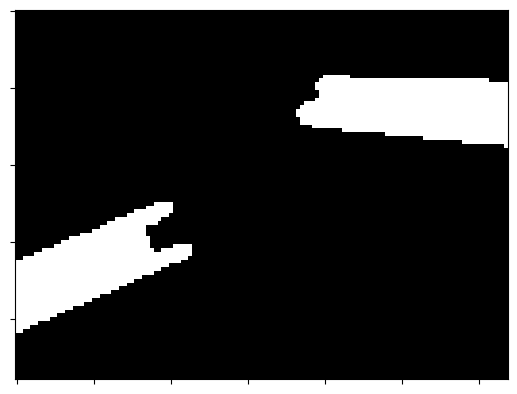

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.imshow(reshape_to_rgb(output_to_tensor[0])[:,:,0], cmap = "gray")
ax.set_xticklabels([])
ax.set_yticklabels([])